In [3]:
import pandas as pd
from math import floor
import numpy as np
from pathlib import Path
import PIL
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory, img_to_array, array_to_img
from matplotlib import pyplot as plt

In [6]:
train_data_dir = Path("train")
test_data_dir = Path("test")

In [7]:
image_count = len(list(train_data_dir.glob('*/*.jpg'))) + len(list(test_data_dir.glob('*/*.jpg')))
print(image_count)

9208


In [8]:
train_Normal = list(train_data_dir.glob('Normal/*'))

train_COVID19 = list(train_data_dir.glob('COVID-19/*'))

train_Pneumonia = list(train_data_dir.glob('Pneumonia/*'))

test_Normal = list(test_data_dir.glob('Normal/*'))

test_COVID19 = list(test_data_dir.glob('COVID-19/*'))

test_Pneumonia = list(test_data_dir.glob('Pneumonia/*'))

In [9]:
train_y = []
for i in range(len(train_COVID19)):
        train_y.append(0)
for i in range(len(train_Normal)):
        train_y.append(1)
for i in range(len(train_Pneumonia)):
        train_y.append(2)
test_y = []
for i in range(len(test_COVID19)):
        test_y.append(0)
for i in range(len(test_Normal)):
        test_y.append(1)
for i in range(len(test_Pneumonia)):
        test_y.append(2)
len(train_y), len(test_y)

(7365, 1843)

In [4]:
# Normal = list(data_dir.glob('Normal/*'))

# COVID19 = list(data_dir.glob('COVID-19/*'))

# Pneumonia = list(data_dir.glob('Pneumonia/*'))

#Pneumonia_Viral = list(data_dir.glob('Pneumonia-Viral/*'))


In [10]:
batch_size = 256
img_height = 48
img_width = 48

In [11]:
train_ds = image_dataset_from_directory(
  train_data_dir, 
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale")

Found 7365 files belonging to 3 classes.


In [12]:
train_ds.class_names

['COVID-19', 'Normal', 'Pneumonia']

In [13]:
val_ds = image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode="grayscale")

Found 1843 files belonging to 3 classes.


In [14]:
class_names = train_ds.class_names
class_names

['COVID-19', 'Normal', 'Pneumonia']

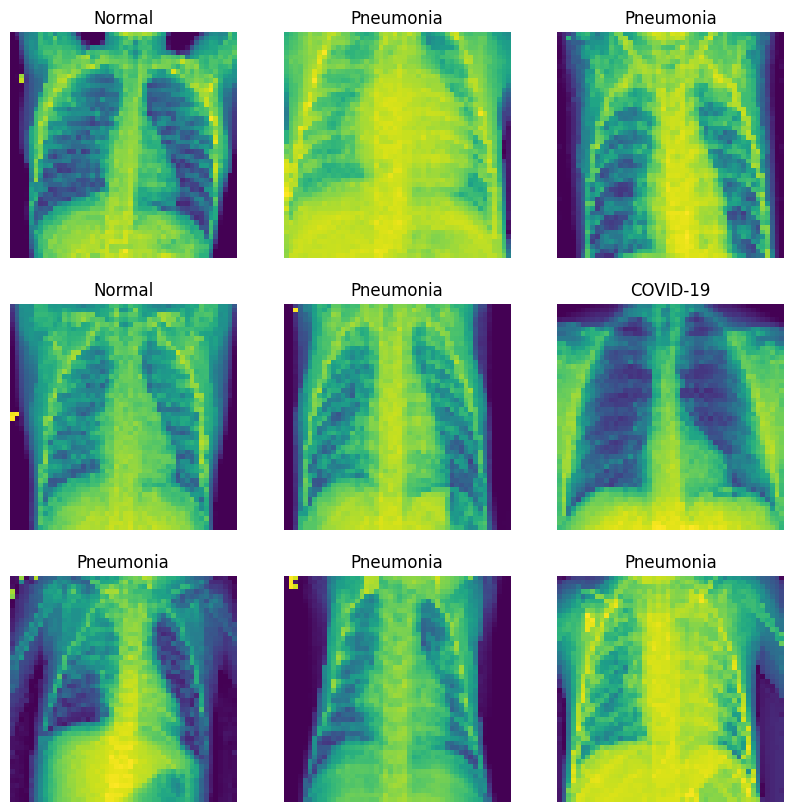

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.98032045


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
class_count = len(class_names)

In [20]:
class_count

3

# Creating a Neural Network

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [27]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['Accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 4096)             

In [30]:
checkpoint = ModelCheckpoint(filepath="PneumoniaModel.keras", monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=3)

earlystopper = EarlyStopping(monitor='val_loss', patience=4)

callbackslist = [checkpoint, earlystopper]

In [31]:
model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbackslist)

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 2.8773 - Accuracy: 0.5424 
Epoch 1: val_loss improved from inf to 0.59173, saving model to PneumoniaModel.keras
29/29 [==============================] - 132s 4s/step - loss: 2.8773 - Accuracy: 0.5424 - val_loss: 0.5917 - val_Accuracy: 0.8334
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 0.5437 - Accuracy: 0.7900
Epoch 2: val_loss improved from 0.59173 to 0.37972, saving model to PneumoniaModel.keras
29/29 [==============================] - 0s 13ms/step - loss: 0.5437 - Accuracy: 0.7900 - val_loss: 0.3797 - val_Accuracy: 0.8888
Epoch 3/20
25/29 [========================>.....] - ETA: 0s - loss: 0.4117 - Accuracy: 0.8575
Epoch 3: val_loss improved from 0.37972 to 0.25069, saving model to PneumoniaModel.keras
29/29 [==============================] - 0s 13ms/step - loss: 0.4008 - Accuracy: 0.8616 - val_loss: 0.2507 - val_Accuracy: 0.9175
Epoch 4/20
24/29 [=======================>......] - ETA: 0s - lo

In [32]:
train_loss, train_acc = model.evaluate(train_ds, verbose = 0)
test_loss, test_acc = model.evaluate(val_ds, verbose = 0)

In [33]:
print("Training Accuracy: %5.2f\nTraining Loss: %5.2f \n"%(train_acc*100, train_loss))
print("Testing Accuracy: %5.2f \nTesting Loss: %5.2f"%(test_acc*100, test_loss))

Training Accuracy: 97.52
Training Loss:  0.08 

Testing Accuracy: 95.93 
Testing Loss:  0.16


In [34]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("PneumoniaModel.keras")

In [35]:
Normal = list(test_data_dir.glob('Normal/*'))

COVID19 = list(test_data_dir.glob('COVID-19/*'))

Pneumonia = list(test_data_dir.glob('Pneumonia/*'))

In [36]:
true_y = []
j = 0
i=1
for i in range(len(COVID19)):
        true_y.append(0)
for i in range(len(Normal)):
        true_y.append(1)
for i in range(len(Pneumonia)):
        true_y.append(2)
len(true_y)

1843

In [37]:
test = []

for i in range(len(COVID19)):
    test.append(PIL.Image.open(str(COVID19[i])))
for i in range(len(Normal)):
    test.append(PIL.Image.open(str(Normal[i])))
for i in range(len(Pneumonia)):
    test.append(PIL.Image.open(str(Pneumonia[i])))

In [38]:
def prediction(image):
    image_resized = image.resize((48,48))
    image_resized = image_resized.convert("L")
    image_resized = (np.expand_dims(image_resized,0))
    predictions = loaded_model.predict(image_resized, verbose=0)
    pred=np.argmax(predictions)
    return pred

In [39]:
preds = []
for i in test:
    preds.append(prediction(i))

In [41]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, cohen_kappa_score, confusion_matrix

In [42]:
print("Accuracy Score is ",accuracy_score(true_y, preds))
print("Recall Score is ",recall_score(true_y, preds, average='macro'))
print("Precision Score is ",precision_score(true_y, preds, average='macro'))
print("Cohen Kappa Score is ",cohen_kappa_score(true_y, preds))
print("Confusion Matrix is \n",confusion_matrix(true_y, preds))

Accuracy Score is  0.9560499186109603
Recall Score is  0.9542845987048625
Precision Score is  0.9510893922564095
Cohen Kappa Score is  0.9266570731906234
Confusion Matrix is 
 [[245   4   8]
 [  8 618  28]
 [  9  24 899]]


In [43]:
def prediction_decode(image):
    image_resized = image.resize((48,48))
    image_resized = image_resized.convert("L")
    image_resized = (np.expand_dims(image_resized,0))
    predictions = loaded_model.predict(image_resized, verbose=0)
    pred=np.argmax(predictions)
    return class_names[pred]

In [44]:
prediction_decode(test[350])

'Normal'

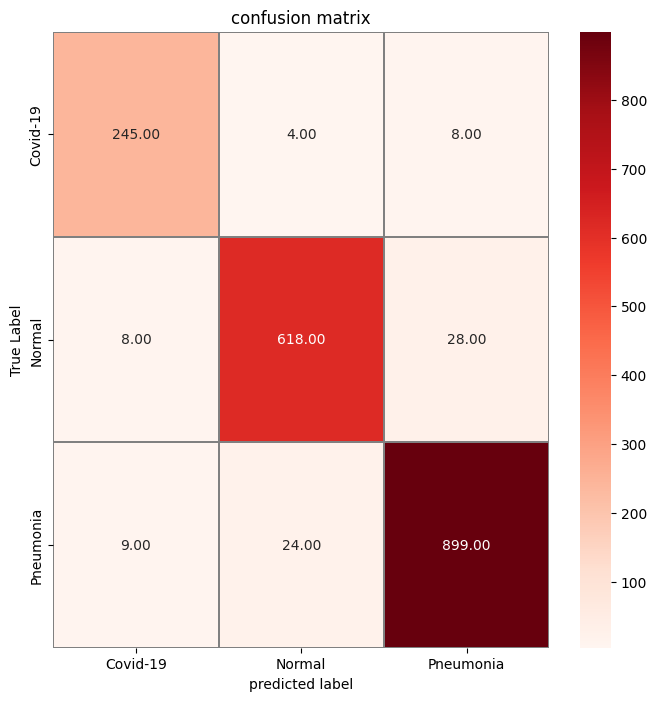

In [45]:
confusion_mtx = confusion_matrix(true_y, preds)
target_names = ['Covid-19', 'Normal', 'Pneumonia']
plt.figure(figsize = (8,8))
sns.heatmap(confusion_mtx,cmap= "Reds", linecolor = 'gray' , linewidth = 0.01 , annot = True, fmt='.2f' , xticklabels = target_names , yticklabels = target_names)
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()